# Predicting House Prices 

Nowadays, housing prices are extremely on the rise due to the increase in demand. It is really hard to get your hands on a house and even if you do, it has become normal to pay much more than the original sales price of the house.

When thinking about the sales price of a house, most people think this is a combination of the size of the lot, the amount of bedrooms and the location. However, many more unfamiliar features determine the sales price of a house. Given a dataset with 79 features, both a mixture of categorical and numerical features, we are going to estimate the value of houses in Ames Iowa. Since there are only 1460 training examples the challenge to train a model that generalizes well to new examples arises. To solve this problem, we will decrease the amount of features in the dataset. Reducing the amount of features in the dataset will improve accuracy because there is less misleading data on which the model is trained.
	Creating a model which predicts housing prices will help to solve real world problems because housing prices can in this way be computed in a more rational way. Moreover...

## Data analysis and preprocessing

Before we start with the actual model, it is of use to first inspect the data we are working with.




In [1]:
import pandas as pd 

import seaborn as sns

import matplotlib.pyplot as plt

import numpy as np

from math import sqrt

from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


In [2]:
# import the csv files into pandas dataframe
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
test_data_submission = pd.read_csv('data/sample_submission.csv')


## Data visualization 

/Users/veerleblom/opt/anaconda3/envs/progLab/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

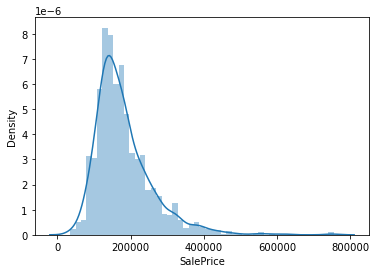

In [3]:
# select the Sale price from the training data = y 
y_train = train_data['SalePrice']

# create histogram with seaborn of the Sale price (y) from train and test data
sns.distplot(y_train)


As you can see in the plot, most of the houses are sold for a price between 100000 and 200000 dollars. However, there are outliers on the precier side.

## Preprocessing

The data consist of both categorical as numerical data.
In addition, there are a few missing values in the data which should be handled as well.

### STEP 1: Correcting the missing values from the data

Approach: replace the missing values of every numeric column with the mean of this column.

The missing values in the categorical data will be replaced with the most common categorical value in that column. 

We choose not to delete the rows of each missing value as the dataset is rather small.

In [4]:
def cleaning(dataframe):
    """
    This function corrects any missing values in a pandas dataframe
    returns the cleaned dataframe
    """
    
    # loop through all the features/columns in the training data
    for column in dataframe:

        # check whether the data in each column is numerical
        if is_numeric_dtype(dataframe[column]):

            # if the data is numerical compute the mean of the whole column values
            column_mean = dataframe[column].mean()

            # replace the missing values in this column with the mean of the column
            dataframe[column] = dataframe[column].fillna(column_mean)

        # also replace categorical missing values
        # check this approach!
        else:
            dataframe[column] = dataframe[column].fillna(dataframe[column].value_counts().index[0])
    
    return dataframe

# clean data
train_df = cleaning(train_data)
test_x = cleaning(test_data)
test_y = cleaning(test_data_submission)


### STEP 2: Check correlations between features

We only want to compare which features in our dataset have significant influence on the housing price. We are not interested in which features correlate significantly with other features. 

#### Visualize the correlation in the training data with a heatmap

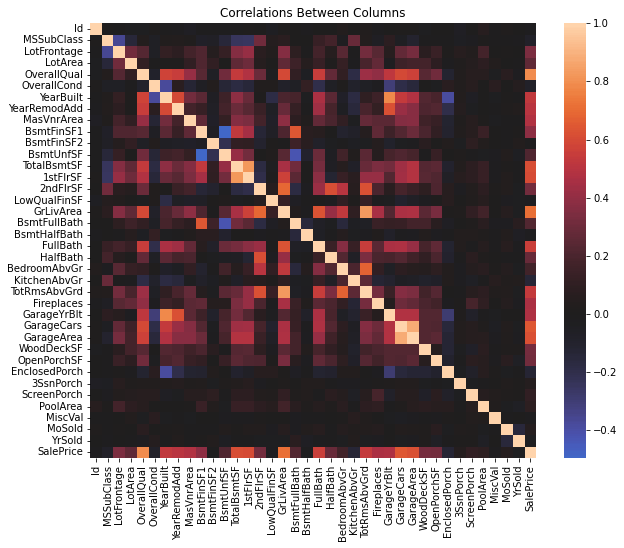

In [5]:
plt.figure(figsize=(10,8))
sns.heatmap(train_df.corr(), center = 0)
plt.title("Correlations Between Columns")
plt.show()

#### Compute correlation coefficients 

##### Degree of correlation:

- Perfect: If the value is near ± 1, then it said to be a perfect correlation: as one variable increases, the other variable tends to also increase (if positive) or decrease (if negative).
- High degree: If the coefficient value lies between ± 0.50 and ± 1, then it is said to be a strong correlation.
- Moderate degree: If the value lies between ± 0.30 and ± 0.49, then it is said to be a medium correlation.
- Low degree: When the value lies below + .29, then it is said to be a small correlation.
- No correlation: When the value is zero

https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/pearsons-correlation-coefficient/ 

In [6]:
# compute correlation coefficients
train_df.corr(method="pearson")

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.011156,-0.009601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050199,-0.005024,...,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
MSSubClass,0.011156,1.000000,-0.357056,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022895,-0.069836,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.009601,-0.357056,1.000000,0.306795,0.234196,-0.052820,0.117598,0.082746,0.179283,0.215828,...,0.077106,0.137454,0.009790,0.062335,0.037684,0.180868,0.001168,0.010158,0.006768,0.334901
LotArea,-0.033226,-0.139781,0.306795,1.000000,0.105806,-0.005636,0.014228,0.013788,0.103960,0.214103,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,-0.028365,0.032628,0.234196,0.105806,1.000000,-0.091932,0.572323,0.550684,0.410238,0.239666,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,0.012609,-0.059316,-0.052820,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.127788,-0.046231,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,-0.012713,0.027850,0.117598,0.014228,0.572323,-0.375983,1.000000,0.592855,0.314745,0.249503,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,-0.021998,0.040581,0.082746,0.013788,0.550684,0.073741,0.592855,1.000000,0.179186,0.128451,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,-0.050199,0.022895,0.179283,0.103960,0.410238,-0.127788,0.314745,0.179186,1.000000,0.263582,...,0.159349,0.124965,-0.109849,0.018795,0.061453,0.011723,-0.029815,-0.005940,-0.008184,0.475241
BsmtFinSF1,-0.005024,-0.069836,0.215828,0.214103,0.239666,-0.046231,0.249503,0.128451,0.263582,1.000000,...,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420


#### Remove any signicant correlations?

Maybe in later steps...
Decide which features are of no use.. 

### STEP 3: Handle categorical data

Considering the different models we could implement to predicting housing prices differ in the way they handle categorical data. Decision trees for example, are excellent in handeling categorical data while neural networks cannot. 

This section can be skipped or further examined depending on our final choice of the model. 

Options for handelling categorical values:
1. Label encoding: give every category an integer label. However, this approach also comes with a problem. You will/can create a sequence in the categories and therefore can be misinterpreted by your algorithm.

2. Turn the categorical values in a one-hot encoding matrix, which is in general most used in practise. This approach is however not usefull when having features with many categories as it exponentially increases the number of columns in your data. 

In our data, the one-hot encoding matrix seems most usefull.

Again this section will be executed when there is an uniform decision made about the kind of model we are going to use.

https://towardsdatascience.com/an-overview-of-categorical-input-handling-for-neural-networks-c172ba552dee
https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd 

## Predicting House Prices with Linear Regression

The target variable that we are trying to predict is a property's sale price in dollars. We decided to first start  simple Linear Regression models, starting with a single feature. 

To decide which feature to start with, we took a look at the heatmap computed before, and chose the features which correlated the most with the sale price. In other words, we determined the features which are most important for determining the sale price.

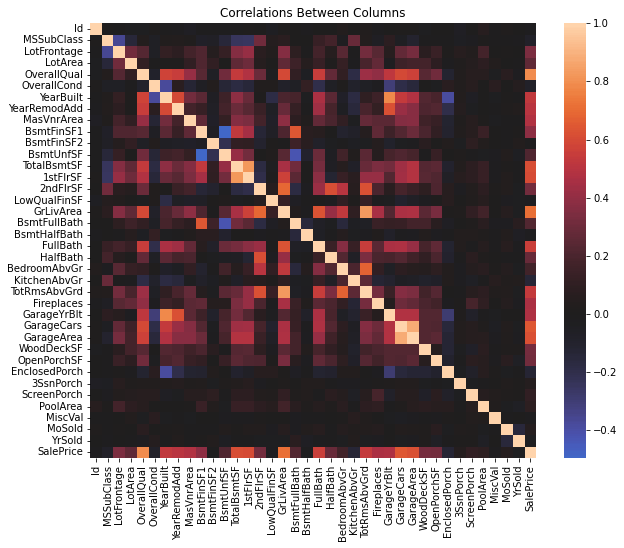

In [7]:
plt.figure(figsize=(10,8))
sns.heatmap(train_df.corr(), center = 0)
plt.title("Correlations Between Columns")
plt.show()

As visible in the heat map GrLivArea, OverallQual & GarageCars have a high correlation with the sales price of houses. Therefore, we will first create a model which predicts the sales price of a house according to a given value for these features.

In [8]:
# select data
X_train = train_data.loc[:, ~train_data.columns.isin(['SaleType', 'SaleCondition', 'SalePrice'])]
y_train = train_data['SalePrice']

X_test = test_data.loc[:, ~test_data.columns.isin(['SaleType', 'SaleCondition'])]
y_test = test_data_submission['SalePrice']


## Univariate linear regression

### 1. GrLivArea: Above grade (ground) living area square feet

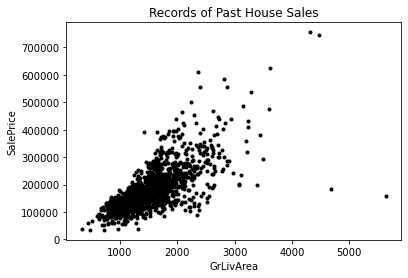

In [9]:
X_train_GrLivArea = X_train['GrLivArea']
X_test_GrLivArea = X_test['GrLivArea']

plt.plot(X_train_GrLivArea, y_train, '.', color='black');
plt.title('Records of Past House Sales')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

In general, the price of a house is higher when the living area is larger. However, there are a few outliers visible of houses with a large living are which are sold for a relatively small price.

In [10]:
# reshape the data so our sklearn linear regression model can work with the data
X_train_GrLivArea = X_train_GrLivArea.values.reshape(-1, 1)
X_test_GrLivArea = X_test_GrLivArea.values.reshape(-1, 1)

# create object for the class
linear_regressor1 = LinearRegression()

# perform linear regression
linear_regressor1.fit(X_train_GrLivArea, y_train)

# make predictions
y_pred_GrLivArea = linear_regressor1.predict(X_test_GrLivArea)

print("Coefficients:", linear_regressor1.coef_)
print("Intercept:", linear_regressor1.intercept_)

Coefficients: [107.13035897]
Intercept: 18569.02585648722


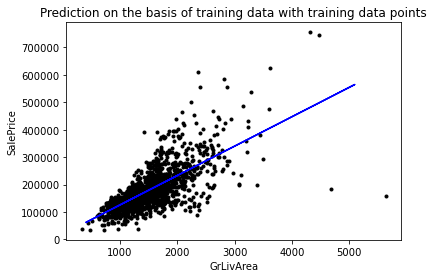

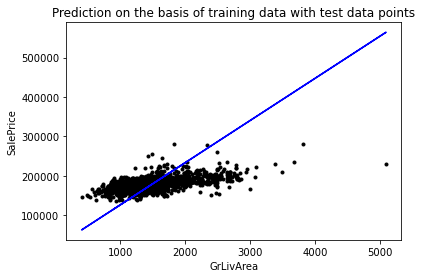

In [11]:
# plot train data and univariate linear regression line
plt.plot(X_train_GrLivArea, y_train, '.', color='black')
plt.plot(X_test_GrLivArea, y_pred_GrLivArea, color='blue');
plt.title('Prediction on the basis of training data with training data points')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

# plot test data and univariate linear regression line
plt.plot(X_test_GrLivArea, y_test, '.', color='black')
plt.plot(X_test_GrLivArea, y_pred_GrLivArea, color='blue');
plt.title('Prediction on the basis of training data with test data points')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

To calculate the difference between the actual values of y and the predicted values of y we will use the root-mean-squared-error (RMSE). The RMSE is the standard deviation of prediction errors. These prediction errors are also known as residuals, which is a measure of how far the data points are from the regression line. It tells us how concentrated our data is around the line with the best possible fit. A lower value indicates a better fit to the data.

In [12]:
# compute root mean squared error 
rmse = np.sqrt(mean_squared_error(y_pred_GrLivArea, y_test))
print("RMSE:", rmse)

RMSE: 44784.302527635606


We now computed a prediction for the feature GrLivArea, we will repeat the same for the other two features, OverallQual and GarageSale.

### 2. OverallQual: Overall material and finish quality

In [13]:
X_train_OverallQual = X_train['OverallQual']
X_test_OverallQual = X_test['OverallQual']


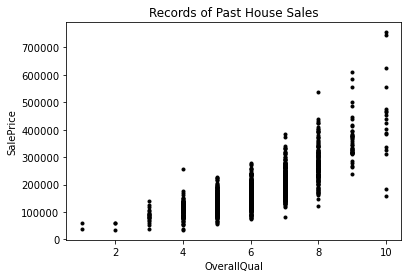

In [14]:
plt.plot(X_train_OverallQual, y_train, '.', color='black');
plt.title('Records of Past House Sales')
plt.xlabel('OverallQual')
plt.ylabel('SalePrice')
plt.show()

In general, the price of a house is higher when the overall material and finish quality are higher.

In [15]:
X_train_OverallQual = X_train_OverallQual.values.reshape(-1, 1)
X_test_OverallQual = X_test_OverallQual.values.reshape(-1, 1)

In [16]:
# create object for the class
linear_regressor2 = LinearRegression() 

# perform linear regression
linear_regressor2.fit(X_train_OverallQual, y_train) 

# make predictions
y_pred_OverallQual = linear_regressor2.predict(X_test_OverallQual)  

print("Coefficients:", linear_regressor2.coef_)
print("Intercept:", linear_regressor2.intercept_)

Coefficients: [45435.8025931]
Intercept: -96206.07951476038


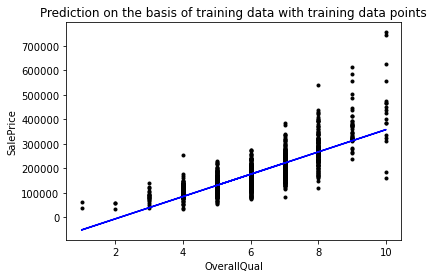

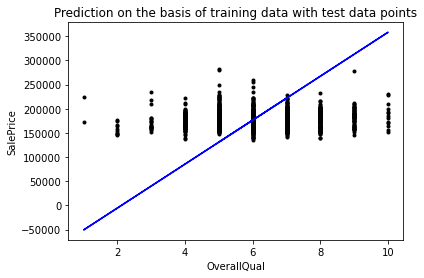

In [17]:
# plot train data and univariate linear regression line
plt.plot(X_train_OverallQual, y_train, '.', color='black')
plt.plot(X_test_OverallQual, y_pred_OverallQual, color='blue');
plt.title('Prediction on the basis of training data with training data points')
plt.xlabel('OverallQual')
plt.ylabel('SalePrice')
plt.show()

# plot test data and univariate linear regression line
plt.plot(X_test_OverallQual, y_test, '.', color='black')
plt.plot(X_test_OverallQual, y_pred_OverallQual, color='blue');
plt.title('Prediction on the basis of training data with test data points')
plt.xlabel('OverallQual')
plt.ylabel('SalePrice')
plt.show()

In [18]:
rmse = np.sqrt(mean_squared_error(y_pred_OverallQual, y_test))
print("RMSE:", rmse)

RMSE: 65805.78700340052


### 3. GarageArea: Size of garage in sqaure feet


In [19]:
X_train_GarageArea = X_train['GarageArea']
X_test_GarageArea = X_test['GarageArea']

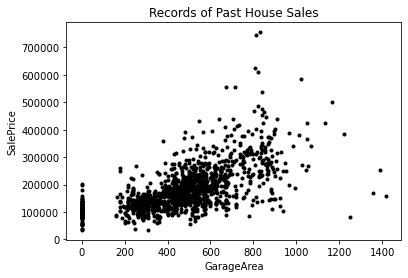

In [20]:
plt.plot(X_train_GarageArea, y_train, '.', color='black');
plt.title('Records of Past House Sales')
plt.xlabel('GarageArea')
plt.ylabel('SalePrice')
plt.show()

In [21]:
X_train_GarageArea = X_train_GarageArea.values.reshape(-1, 1)
X_test_GarageArea = X_test_GarageArea.values.reshape(-1, 1)

In [22]:
# create object for the class
linear_regressor3 = LinearRegression()

# perform linear regression
linear_regressor3.fit(X_train_GarageArea, y_train) 

# make predictions
y_pred_GarageArea = linear_regressor3.predict(X_test_GarageArea)  

print("Coefficients:", linear_regressor3.coef_)
print("Intercept:", linear_regressor3.intercept_)

Coefficients: [231.64561451]
Intercept: 71357.42140747693


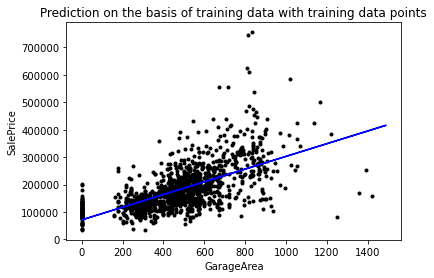

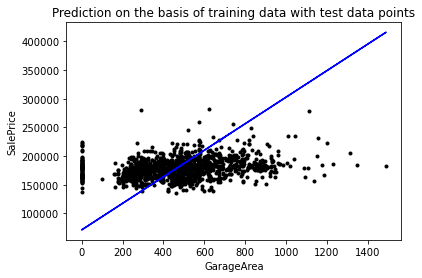

In [23]:
# plot train data and univariate linear regression line
plt.plot(X_train_GarageArea, y_train, '.', color='black')
plt.plot(X_test_GarageArea, y_pred_GarageArea, color='blue');
plt.title('Prediction on the basis of training data with training data points')
plt.xlabel('GarageArea')
plt.ylabel('SalePrice')
plt.show()

# plot test data and univariate linear regression line
plt.plot(X_test_GarageArea, y_test, '.', color='black')
plt.plot(X_test_GarageArea, y_pred_GarageArea, color='blue');
plt.title('Prediction on the basis of training data with test data points')
plt.xlabel('GarageArea')
plt.ylabel('SalePrice')
plt.show()


In [24]:
rmse = np.sqrt(mean_squared_error(y_pred_GarageArea, y_test))
print("RMSE:", rmse)


RMSE: 48822.95583580953


## Redivide data

After plotting the graphs, we found out that the test data differs a lot from the train data. For this reason, we decided to merge the devided datasets and randomly redivide it into a train and test data set. We will work this out in the next milestone.

## Multivariate linear regression

In this step, we are going to create a linear regression model, combining multiple features to predict the house price.

In [25]:
X_train_mv = train_data[['OverallQual', 'GrLivArea', 'GarageArea']]
y_train = train_data['SalePrice']

X_test_mv = test_data[['OverallQual', 'GrLivArea', 'GarageArea']]
y_test = test_data_submission['SalePrice']

print(X_train_mv)


      OverallQual  GrLivArea  GarageArea
0               7       1710         548
1               6       1262         460
2               7       1786         608
3               7       1717         642
4               8       2198         836
...           ...        ...         ...
1455            6       1647         460
1456            6       2073         500
1457            7       2340         252
1458            5       1078         240
1459            5       1256         276

[1460 rows x 3 columns]


When we implement multiple features in our model it is important to consider the scale of each feature. As number of bedrooms and the total area of the house for example can differ a lot in values ranges. To fix this problem we applyed mean data normalization. 


In [26]:
scaler = MinMaxScaler()
X_train_mv = scaler.fit_transform(X_train_mv)
X_test_mv = scaler.transform(X_test_mv)


In [27]:
# create object for the class
mv_linear_regressor = LinearRegression()

# perform multivariate linear regression
mv_linear_regressor.fit(X_train_mv, y_train)

# make predictions
y_pred_mv = mv_linear_regressor.predict(X_test_mv)

print("Coefficients:", mv_linear_regressor.coef_)
print("Intercept:", mv_linear_regressor.intercept_)

Coefficients: [251197.0657364  263538.56973477 103440.02246176]
Intercept: -54566.430123887374


In [28]:
rmse = np.sqrt(mean_squared_error(y_pred_mv, y_test))
print("RMSE:", rmse)

RMSE: 64727.58644309295


In [29]:
# loss function plotten
# keras (1 linear layer = lineare regressie, zonder activation functions) ipv sk learn


In [30]:
# Since the data we are passing into the model has 3 features, 
# we must define the input_dim parameter in the first layer and 
# set it to 3.
# Since it is a linear regression problem and the output is just 
# one number, the final layer should have one node. 

